# Understanding TARDIS: Monte Carlo Physics and Spectrum Generation

> **Note:** We strongly recommend turning off code autocompletion for this notebook. This exercise is designed to engage your understanding of TARDIS Monte Carlo physics, spectrum generation, and plasma treatments, rather than relying on automated suggestions. In VSCode, you can temporarily disable autocomplete in notebook cells by navigating to **Settings → Notebook: Suggest Enabled** and unchecking the box, or by creating a workspace with a `.vscode/settings.json` file containing `"notebook.suggest.enabled": false`. This will help you focus on understanding the physics behind each step.

In this afternoon session, we'll dive deep into the Monte Carlo radiative transfer physics that powers TARDIS. You'll explore how packets interact with plasma, understand different spectrum types, and investigate advanced physics treatments that affect the final observational results.

In [1]:
from matplotlib import pyplot as plt
from tardis import run_tardis
from tardis.io.configuration.config_reader import Configuration
import numpy as np
from astropy import units as u, constants as const
from pathlib import Path
import pandas as pd

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
from tardis.io.atom_data import download_atom_data
# Download the Kurucz CD23 atomic data for H and He. This is a basic atomic data set. Will not download if already present.
download_atom_data('kurucz_cd23_chianti_H_He_latest')

Atomic Data kurucz_cd23_chianti_H_He_latest already exists in /Users/joshuashields/Downloads/tardis-data/kurucz_cd23_chianti_H_He_latest.h5. Will not download - override with force_download=True.


In [3]:
conf = Configuration.from_yaml('tardis_example.yml') 
conf.montecarlo.no_of_packets=1e4 
conf.montecarlo.iterations = 10  
conf.montecarlo.last_no_of_packets = 1e5
conf.montecarlo.convergence_strategy.stop_if_converged = True
conf.montecarlo.convergence_strategy.hold_iterations = 4

## Setting Up for Deep Analysis

We'll start with a well-converged TARDIS simulation using the parameters you learned to optimize in the morning session. This allows us to focus on understanding the detailed physics rather than convergence issues.

<div style="background-color: #e3f2fd; border-left: 4px solid #2196f3; padding: 10px; margin: 10px 0;">
<strong>**Key Focus:**</strong> Today we're shifting from "making TARDIS work" to "understanding how TARDIS works" - the Monte Carlo physics, spectrum generation, and advanced plasma treatments.
</div>

**$\blacktriangleright$ Do This** - Before running the simulation, think about what we'll explore:

1. **Spectrum Types:** TARDIS generates three different spectra - what might these represent physically?
2. **Monte Carlo Packets:** How do computational packets relate to real photons?
3. **Plasma Physics:** What approximations might TARDIS make, and when might they break down?

In [4]:
sim = run_tardis(conf, virtual_packet_logging=True)

BokehModel(combine_events=True, render_bundle={'docs_json': {'bc938a3f-9b5d-43fb-a253-ba2d1839843a': {'version…

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

# Exploring the Three TARDIS Spectra

TARDIS generates three fundamentally different types of spectra, each representing different aspects of the Monte Carlo radiative transfer process. Understanding their differences is crucial for choosing the right spectrum for your scientific analysis.

**$\blacktriangleright$ TASK: Prediction Exercise** - Answer the following questions before we examine the spectra, recalling the lecture. 

1. **Real packets:** These are the Monte Carlo packets that actually transport energy. What might their spectrum represent?
2. **Virtual packets:** These are created during the final iteration for better sampling. How might this improve the spectrum?
3. **Formal spectrum:** This uses ray-tracing through the converged plasma state. What advantages might this approach have?

<div style="background-color: #fff3e0; border-left: 4px solid #ff9800; padding: 10px; margin: 10px 0;">
<strong>**Important:**</strong> The formal spectrum calculation takes about 3 minutes. It's a post-simulation step that calculates detailed ray-tracing through the plasma. This is normal and expected.
</div>

## Double click this cell and write your thoughts down here, if it helps you organize them. 

## Solution

1. The real spectrum is the result of the real packets. It's still a spectrum and represents the same quantity as the other two spectra, ist just also has the most monte carlo noise of any because it doesn't have any sampling improvement techniques.
2. The virtual spectra don't bounce around inside the ejecta, which makes them more efficient at sampling the spectrum. 
3. The formal spectrum only indirectly relies on monte carlo sampling, so it doesn't show the monte carlo noise inherent to all monte carlo techniques. 

In [5]:
real_spectrum = sim.spectrum_solver.spectrum_real_packets
virtual_spectrum = sim.spectrum_solver.spectrum_virtual_packets
formal_spectrum = sim.spectrum_solver.spectrum_integrated

[py.warnings         ][WARNING]  /Users/joshuashields/codes/tardis/tardis/tardis/spectrum/formal_integral.py:398: UserWarning:

The number of interpolate_shells was not specified. The value was set to 80.

 (warnings.py:110)


(1e+35, 6e+39)

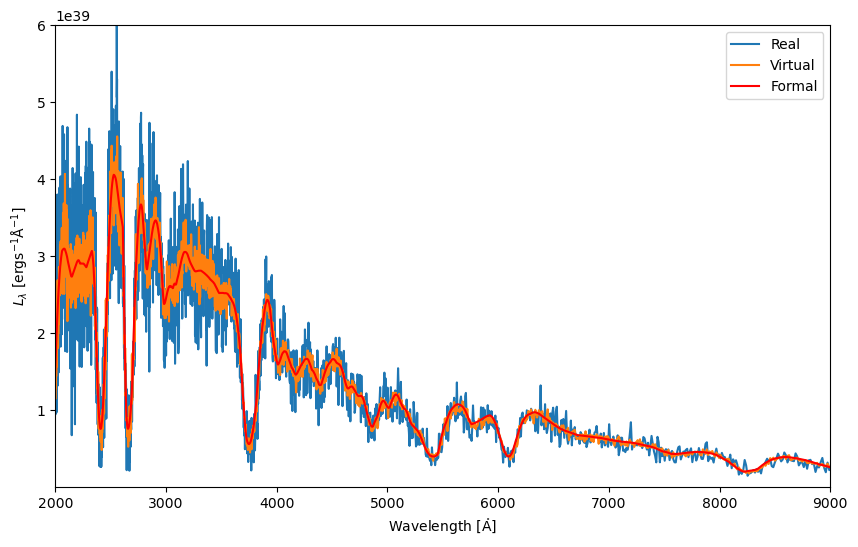

In [6]:
plt.figure(figsize=(10, 6))
real_spectrum.plot(label='Real')
virtual_spectrum.plot(label='Virtual')
formal_spectrum.plot(label='Formal', color='red')
plt.legend()

plt.xlim(2000, 9000)
plt.ylim(1e35, 6e39)

### Analyzing the Spectral Differences

**$\blacktriangleright$ Observe and Analyze** - Look at the three spectra you just plotted:

1. **Noise levels:** Which spectrum appears smoothest? Which is most noisy? Why might this be?
2. **Overall shape:** Do all three spectra trace the same general spectral features?
3. **Computational cost:** Consider that real packets run for all iterations, virtual packets only in the final iteration, and formal spectrum is post-processing. How does this relate to what you observe?

**Think about it:** Each spectrum represents a different way of extracting observational predictions from the same underlying Monte Carlo simulation. Understanding when to use each type is crucial for your research.

1. The formal spectrum appears smoothest, and the real spectrum is the noisiest. This is also explained by the previous solution cell. 
2. All three spectra trace the same shape and features. They do not physically describe different things. Rather, they're just different ways of sampling the same thing. 
3. It's at this point that the student should think about the fact that they don't actually need to run the formal integral or create any virtual packets, technically. They will always get a real spectrum, but the other two spectra are simply techniques to produce less noisy spectra, and they can choose a setup that will is most useful for their use case. 

## Understanding Real Packets: The Foundation of Monte Carlo

Real packets are the heart of TARDIS. These computational particles carry energy through the ejecta and determine the plasma state through their interactions. Understanding how they start their journey reveals fundamental aspects of the Monte Carlo method.

**$\blacktriangleright$ Physics Connection** - Real packets serve dual purposes:

1. **Energy transport:** They carry energy from the inner boundary through the ejecta
2. **Plasma diagnostics:** Their interactions determine ionization and excitation states
3. **Spectrum generation:** Those that escape contribute to the final spectrum

Let's investigate where these packets come from and verify some fundamental physics assumptions.

In [7]:
packets = sim.transport.transport_state.packet_collection

**$\blacktriangleright$ TASK:  Verify the Blackbody Packet Distribution**

TARDIS initializes packets from a blackbody distribution at the inner boundary. Let's verify this fundamental assumption by comparing the packet frequency distribution to the analytic Planck function.

**Your challenge:** Implement the Planck function below and compare it to the actual packet distribution.

The Planck function describes the spectral energy density per unit frequency for blackbody radiation. For a spherical radiating surface, the luminosity per unit frequency is:

$$L_\nu = \pi r^2 \frac{8\pi h \nu^3}{c^2} \frac{1}{e^{h\nu/k_B T} - 1}$$

**Physical meaning:** This represents the energy emission rate per unit frequency from a blackbody sphere at temperature T with radius r.

**$\blacktriangleright$ Implementation Strategy:**
1. Use the simulation's inner boundary temperature and radius
2. Implement the Planck function with proper astropy units
3. Return the result in units compatible with the packet data

In [8]:
def planck_function(nu):
    """
    Calculate the Planck function for a blackbody radiator.
    
    Parameters
    ----------
    nu : astropy.units.Quantity
        Frequency at which to evaluate the Planck function.

    Returns
    -------
    astropy.units.Quantity
        Spectral luminosity [erg s⁻¹ Hz⁻¹].
    """
    T = sim.simulation_state.t_inner
    r_inner = sim.simulation_state.r_inner[0]

    # Your implementation here
    # Use: const.h, const.c, const.k_B, np.pi, np.exp
    # Remember the formula and include the geometric factor for a sphere
    answer = ?
    
    return answer.to(u.erg/u.s/u.Hz)

SyntaxError: invalid syntax (3819320123.py, line 21)

In [10]:
# Solution
def planck_function(nu):
    """
    Calculate the Planck function for a blackbody radiator.
    
    Parameters
    ----------
    nu : astropy.units.Quantity
        Frequency at which to evaluate the Planck function.

    Returns
    -------
    astropy.units.Quantity
        Spectral luminosity [erg s⁻¹ Hz⁻¹].
    """
    T = sim.simulation_state.t_inner
    r_inner = sim.simulation_state.r_inner[0]

    answer = (8 * np.pi**2 * const.h * nu**3 * r_inner**2 / const.c**2) / (np.exp(const.h * nu / (const.k_B * T)) - 1 )

    return answer.to(u.erg/u.s/u.Hz)

The below cell is already set up to appropriately scale the packets to the correct units returned by your Planck function. If you're curious about the choices made to do this, [check out the full tutorial for packet initialization here.](https://tardis-sn.github.io/tardis/physics/montecarlo/initialization.html)

Text(0.5, 1.0, 'Packet Frequency Distribution vs Blackbody Theory')

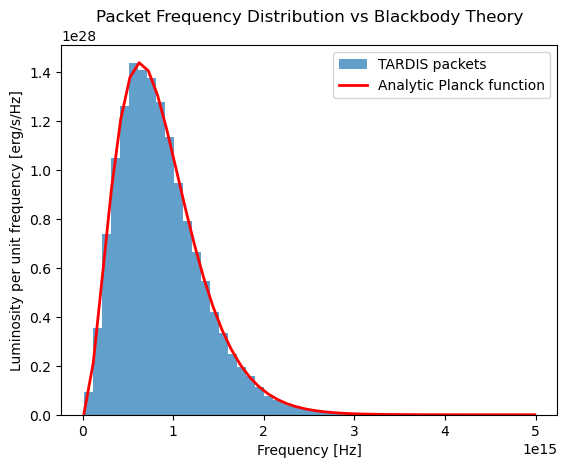

In [11]:
# Set up for comparison plotting
bins = 50  # Number of bins for histogram
sample_nus = np.linspace(min(packets.initial_nus), max(packets.initial_nus), bins) * u.Hz

bin_width = (max(sample_nus) - min(sample_nus)) / bins
lumin_per_packet = packets.initial_energies * u.erg / packets.time_of_simulation / u.s

# Plot the packet frequencies vs analytic Planck function
plt.hist(packets.initial_nus, bins=bins, weights = lumin_per_packet / bin_width, 
         alpha=0.7, label='TARDIS packets', density=False)
plt.plot(sample_nus, planck_function(sample_nus), label='Analytic Planck function', 
         color='red', linewidth=2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Luminosity per unit frequency [erg/s/Hz]')
plt.legend()
plt.title('Packet Frequency Distribution vs Blackbody Theory')

**$\blacktriangleright$ TASK** - Compare your Planck function with the packet distribution:

1. **Agreement quality:** How well do the packet frequencies match the theoretical distribution?
2. **Sampling accuracy:** What does this tell you about TARDIS's Monte Carlo sampling? Think about Monte Carlo techniques and appopriate sampling. 
3. **Physical validation:** Why is this comparison important for trusting the simulation results?


 Note that this is the same process that TARDIS uses with the packets that escape the ejecta to form the output real spectrum. That is, we count up the packets in a bin and divide by the bin width to get the energy per unit frequency or wavelength. 

## Double click to edit this cell and put your thoughts down here. 

## Solution 
1. The packets very closely match the theoretical distribution, but that is also dependent on the number of packets they sample. 
2. This is one of the reasons that using too few packets may give a poor spectrum. There are many distributions that are important in TARDIS, and without enough samples we won't sample them enough to learn the appropriate distribution. 

## Virtual Packets: Improving Spectral Sampling

Virtual packets represent an elegant computational optimization. During the final iteration, whenever a real packet is created or interacts, virtual packets are spawned that stream directly out of the ejecta without further interactions.

**$\blacktriangleright$ The Virtual Packet Strategy:**

Understanding why virtual packets exist reveals important aspects of Monte Carlo efficiency:

1. **Computational efficiency:** Virtual packets don't interact, so they're much faster to compute
2. **Improved sampling:** They provide better spectral statistics without the computational cost of more real packets
3. **Final iteration only:** Since they don't affect the plasma state, they're only needed when generating the final spectrum

Let's explore how their initial directional distribution differs from real packets and understand the physics behind this difference.

Text(0, 0.5, 'Density')

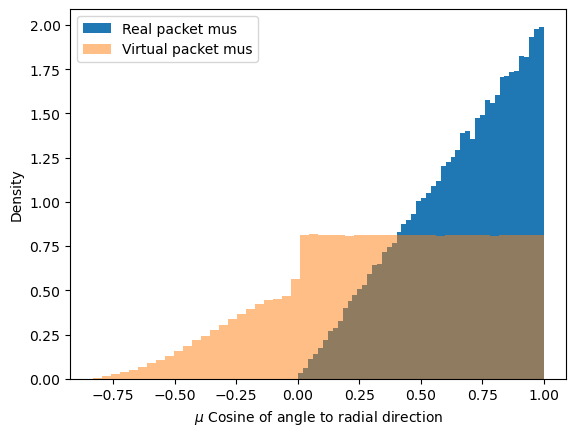

In [12]:
plt.hist(packets.initial_mus, bins=bins, density=True, label='Real packet mus')
plt.hist(sim.transport.transport_state.virt_packet_initial_mus, bins=bins, density=True, alpha=0.5, label='Virtual packet mus')
plt.legend()
plt.xlabel(r'$\mu$ Cosine of angle to radial direction')
plt.ylabel('Density')

### **ANALYZE**: Virtual vs Real Packet Direction Sampling

**$\blacktriangleright$ TASK - Physical Reasoning** - Study the directional distributions and answer:

1. **Negative directions:** Why do virtual packets include negative μ values (backward directions) when real packets don't?

2. **Distribution shape:** Why does the virtual packet distribution have a specific shape for negative directions, then become uniform for μ > 0?

3. **Physical origin:** Real packets start at the inner boundary moving outward. Virtual packets spawn throughout the ejecta. How does this explain the differences?

**Real packet distribution:** Remember that on day 1 we saw that for real packets, μ = √z where z is a random number [0,1].

**Think about it:** The directional distribution reflects where and how these packets are created in the simulation geometry.

## Double click to edit this cell and put your thoughts down here. 

## Solution

1. The student needs to remember that all real packets are initialized at the photosphere, while the virtual packets are created throughout the ejecta. So real packets will never be initialized going in the negative direction. 

2. The virtual packets have this smooth growing distribution for negative directions because the directions accessible depend on how far out in the ejecta the packets are generated. The further out they are, the more negative directions they have available that will still miss the photosphere, and they aren't allowed to spawn in a direction that would hit the photosphere. 

3. I have said this above basically. This is important for understanding the distributions. 

## Formal Spectrum: Ray-Tracing Through Converged Plasma

The formal spectrum uses a fundamentally different approach: ray-tracing. Instead of following Monte Carlo packets, TARDIS shoots rays through the converged plasma state at different impact parameters and wavelengths.

**$\blacktriangleright$ Ray-Tracing vs Monte Carlo:**

The formal spectrum calculation traces rays that:
1. **Move in parallel:** All rays travel in the same direction with different impact parameters
2. **Sample wavelengths systematically:** Rather than stochastic sampling
3. **Include plasma emission:** Rays are both attenuated and amplified by the plasma
4. **Avoid Monte Carlo noise:** But still carry uncertainty from the plasma state

Let's investigate this by examining pre-computed formal spectra with different Monte Carlo sampling to see how plasma uncertainty affects even "smooth" spectra.

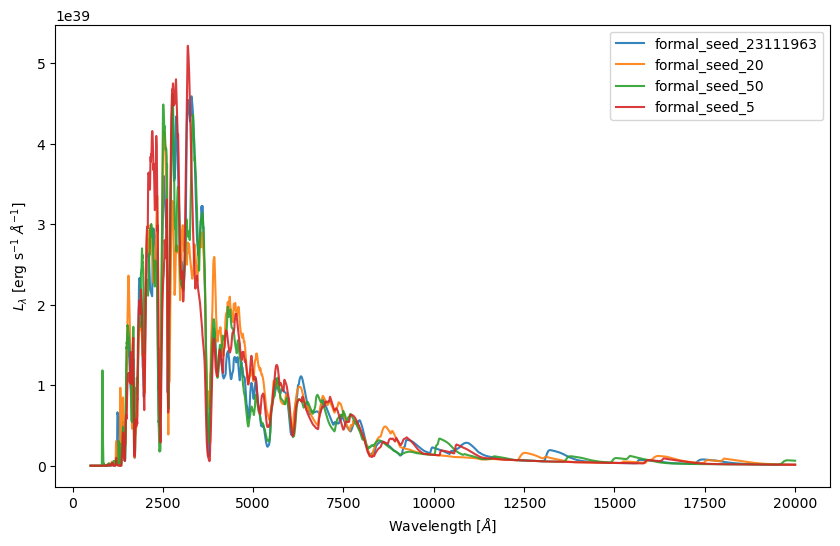

In [13]:
plt.figure(figsize=(10, 6))
for file in Path('formal_spectra_with_seeds').iterdir():
    spec = pd.read_csv(file)
    plt.plot(spec['Wavelength'], spec["Luminosity"], label=file.stem, alpha=0.9)
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'$L_\lambda$ [erg s$^{-1}$ $\AA^{-1}$]')
plt.legend()
    

### Critical Lesson: No Spectrum Type Escapes Poor Convergence

**$\blacktriangleright$ Key Insight** - Notice that even though individual formal spectra appear smooth and noise-free, different Monte Carlo seeds produce dramatically different results.

This demonstrates a crucial point: **convergence checking is essential regardless of which spectrum type you use**. Even the "smooth" formal spectrum depends on the underlying plasma state, which itself depends on Monte Carlo sampling.

**Scientific Impact:** Using unconverged simulations in research can lead to completely incorrect conclusions, even when the spectrum looks visually reasonable.

Let's use the formal spectrum for one more investigation. Because the different impact parameters are sampled across the ejecta, we can use them to ask what the spectrum would look like if we could spatially resolve an explosion. 

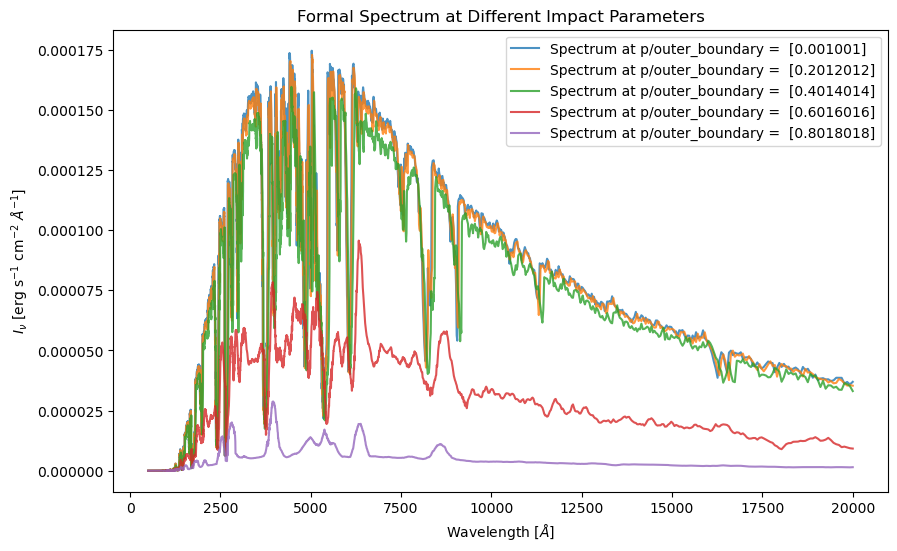

In [45]:
plt.figure(figsize=(10, 6))
for index, spec in enumerate(sim.transport.I_nu_p[:, 1::200].T): # Plotting every 200th spectrum for clarity
    impact_parameter = sim.transport.p_rays[:,index * 200 + 1] * u.cm 
    plt.plot(formal_spectrum.wavelength, spec, label=f'Spectrum at p/outer_boundary =  {impact_parameter / sim.simulation_state.r_outer[-1]}', alpha=0.8)

plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'$I_\nu$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
plt.title('Formal Spectrum at Different Impact Parameters')
plt.legend()

### **ANALYZE**: Understanding Impact Parameter Spectra

**$\blacktriangleright$ TASK - Physical Interpretation** - Study the individual impact parameter spectra:

1. **Geometric effects:** How does the impact parameter (distance from the center) relate to what part of the ejecta the ray samples?

2. **Intensity variation:** Why are some spectra much weaker than others?

3. **Emission vs absorption:** Why do certain spectra appear emission-dominated while others show strong absorption features?

4. **Integration process:** How do you think these individual spectra combine to create the single formal spectrum we observe?

**Think about it:** Each ray samples different physical conditions as it passes through the ejecta at different impact parameters.

## solution
1. The different impact parameters sample the different parts of the ejecta. Large impact parameters are the outside of the ejecta, and small ones are near the inside. 

2. The weak spectra are the ones at the edge of the ejecta. They both don't have a backlight (because they miss the photosphere) and often optically thin. This means you're basically looking through the plasma to the dark sky behind it. 

3. This is related, to the first question. The optically thin spectra are emission dominated because, at these sight lines, you're mostly seeing photons scatter into the line of sight, while the center spectra you get absorption features where photons scatter out of the line of sight or are redistributed by optically thick lines. 

4. You integrate these spectra to form the final formal spectrum, but you also weight them by the area of the circle drawn at a constant impact parameter. So the weaker, outer impact parameters weight more heavily into the final spectra. This is a fine point though that is not necessarily important for the students to understand. 


When you're ready, continue on to the 4th notebook for today that talks about line interaction and estimators. 

In [48]:
from IPython import get_ipython
from pathlib import Path
ip = get_ipython()
path = None
if '__vsc_ipynb_file__' in ip.user_ns:
    path = ip.user_ns['__vsc_ipynb_file__']

nb_path = Path(path)
# Get the current notebook name
current_notebook = nb_path.name

# Create the student version by replacing 'instructor' with 'student'
output_notebook = current_notebook.replace('instructor', 'student')

# Run the nbconvert command
!jupyter nbconvert {current_notebook} --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags="['solution']" --to notebook --output {output_notebook}

print(f"Converted {current_notebook} to {output_notebook}")


[NbConvertApp] Converting notebook 3_tardis_deep_dive_instructor.ipynb to notebook
[NbConvertApp] Writing 555152 bytes to 3_tardis_deep_dive_student.ipynb
Converted 3_tardis_deep_dive_instructor.ipynb to 3_tardis_deep_dive_student.ipynb
